In [1]:
import os
import sys
import scipy

import numpy as np
import moviepy.editor as mpy
from moviepy.video.io.bindings import mplfig_to_npimage

from scipy import stats
from matplotlib import pyplot as plt, rcParams, rc
from sklearn import decomposition

%matplotlib inline
%precision 4
%config InlineBackend.figure_format = 'retina'

rc('animation', html='html5')
rcParams['figure.figsize'] = 8, 10
np.set_printoptions(precision=4, linewidth=100)

## Load the video

In [2]:
video = mpy.VideoFileClip('data/Video_003.avi') # you need to download the video file to this location
video.subclip(0, 50).ipython_display(width=500)

100%|█████████▉| 350/351 [00:00<00:00, 574.80it/s]


In [3]:
!rm __temp__.mp4

In [4]:
video.duration, video.size

(113.5700, [320, 240])

## Helper functions

In [5]:
def create_data_matrix_from_video(clip, k, scale):
    frames = []
    for i in range(k * int(clip.duration)):
        frame = clip.get_frame(i / float(k))
        frame = rgb2grey(frame).astype(int)
        frame = scipy.misc.imresize(frame, scale).flatten()
        frames.append(frame)
    return np.vstack(frames).T # stack images horizontally

def rgb2grey(rgb):
    return np.dot(rgb[..., :3], [0.299, 0.587, 0.114])

def plot_images(M, A, E, index_array, dims, filename=None):
    f = plt.figure(figsize=(15, 10))
    r = len(index_array)
    pics = r * 3
    for k, i in enumerate(index_array):
        for j, mat in enumerate([M, A, E]):
            sp = f.add_subplot(r, 3, 3*k + j + 1)
            sp.axis('Off')
            if isinstance(pixels, scipy.sparse.csr_matrix):
                pixels = pixels.todense()
            plt.imshow(np.reshape(pixels, dims), cmap='gray')
    return f

## Video matrix

In [6]:
# change resolution of image
scale = 50 # scale to X percent (100 means no scaling). CHANGE THIS FOR BETTER RESOLUTION
original_width = video.size[1]
original_height = video.size[0]

dims = (int(original_width * scale / 100), int(original_height * scale / 100))
dims # single frame dimensions (height x width)

(120, 160)

In [7]:
fps = 100
M = create_data_matrix_from_video(video, fps, scale)
np.save('data/video_matrix', M)
M.shape, dims

((19200, 11300), (120, 160))

## Simple foreground and background separation

Show some frame from the video matrix

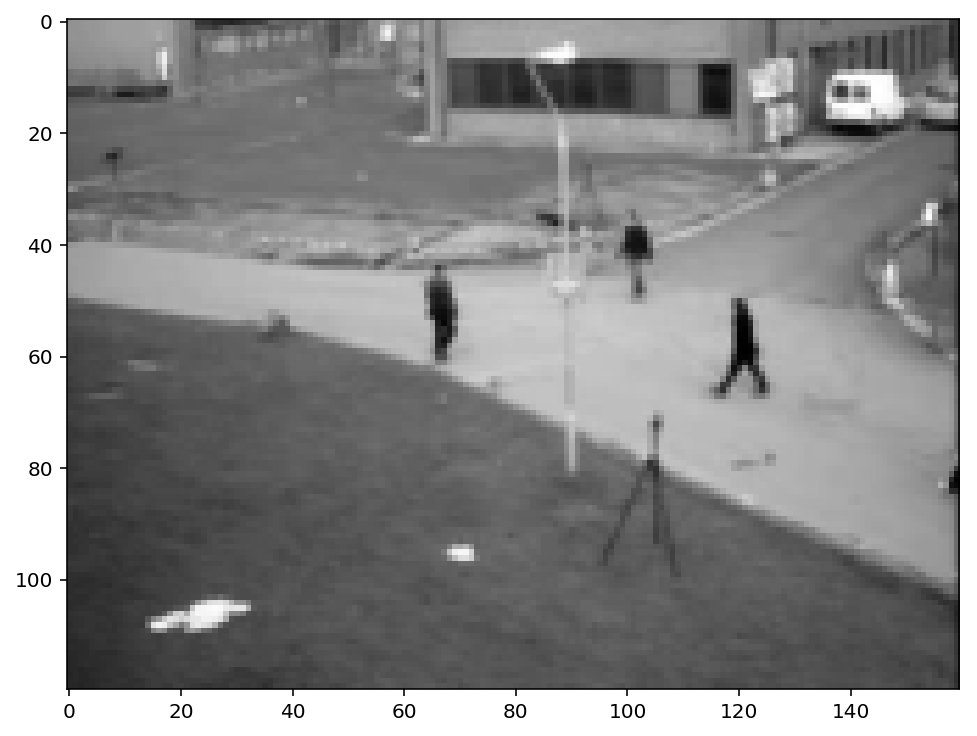

In [8]:
test_image = M[:,140].reshape(dims)
plt.imshow(test_image, cmap='gray');

Show the entire video matrix

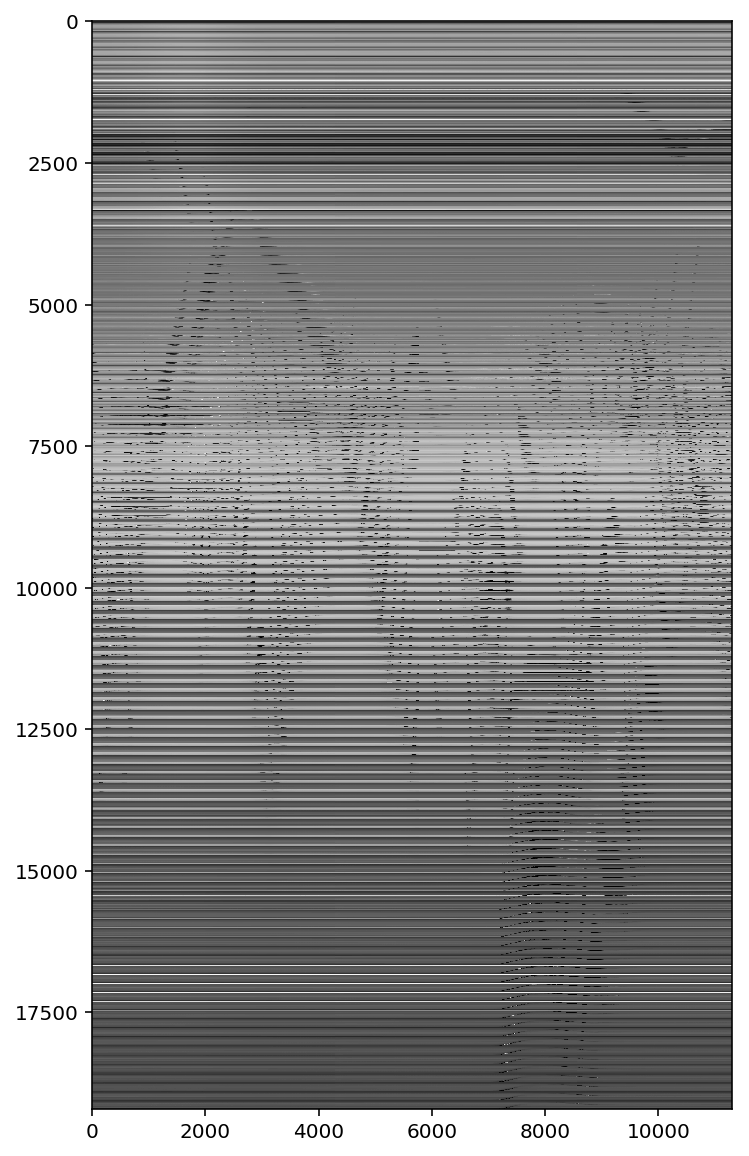

In [9]:
# this might take a while ...
plt.imshow(M, cmap='gray');

Get the background by sampling some columns and taking the mode

In [10]:
# this takes a while...
random_columns = np.random.randint(0, M.shape[1], 1000)
background = stats.mode(M[:, random_columns], axis=1).mode
np.save('data/background', background)
background.shape

(19200, 1)

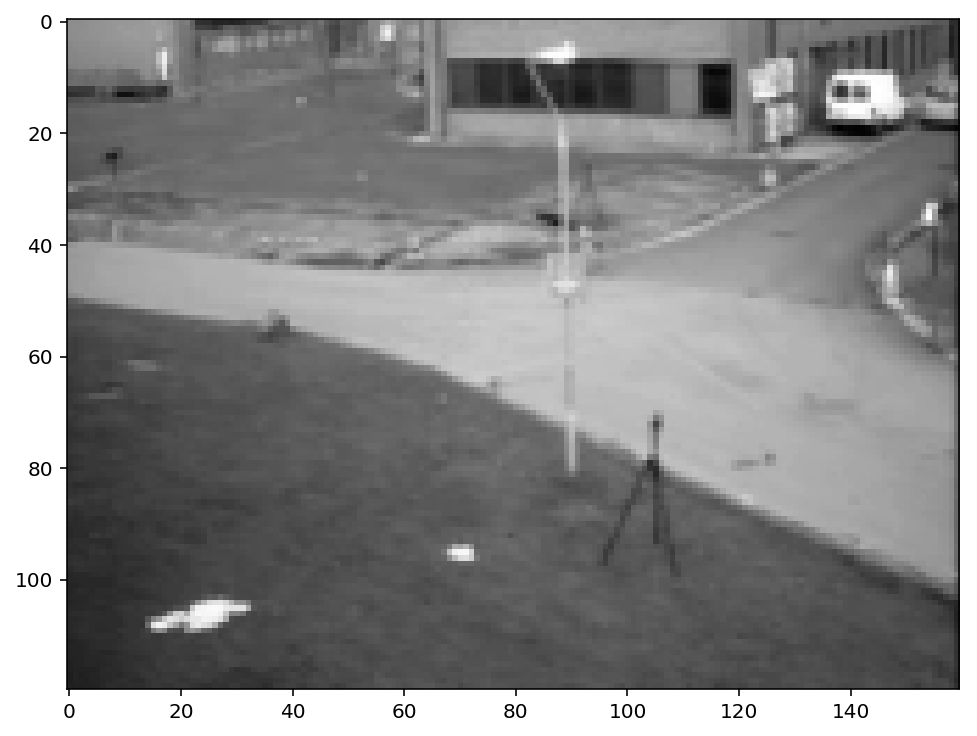

In [11]:
plt.imshow(background.reshape(dims), cmap='gray');

Extract only the people

In [12]:
people = M - background
people.shape

(19200, 11300)

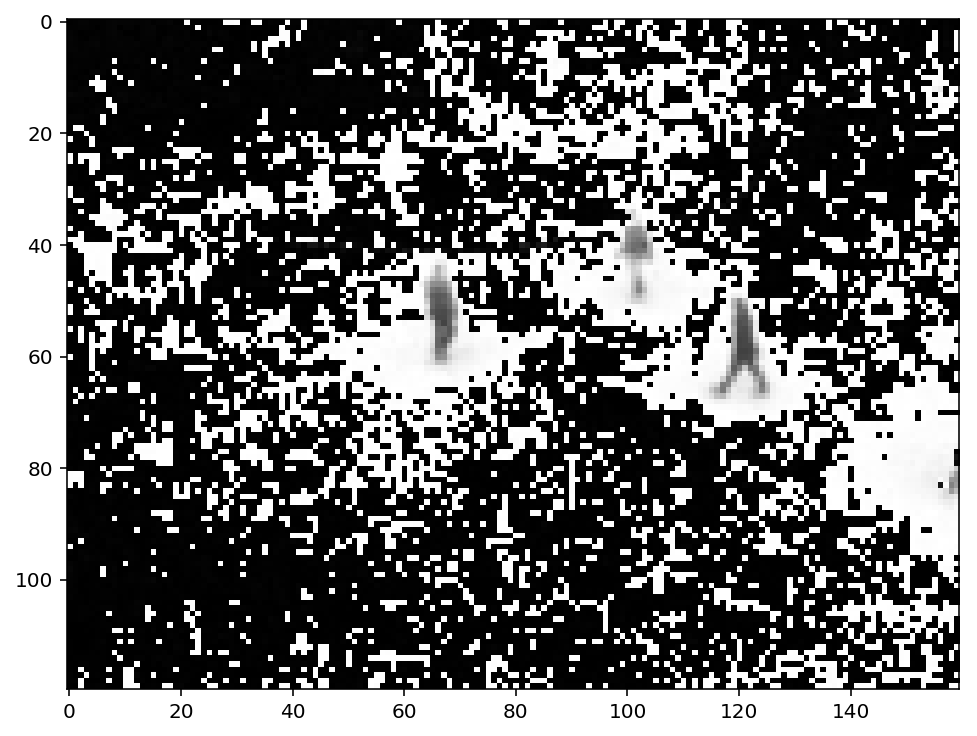

In [13]:
plt.imshow(people[:,140].reshape(dims), cmap='gray');

Clean up the noise

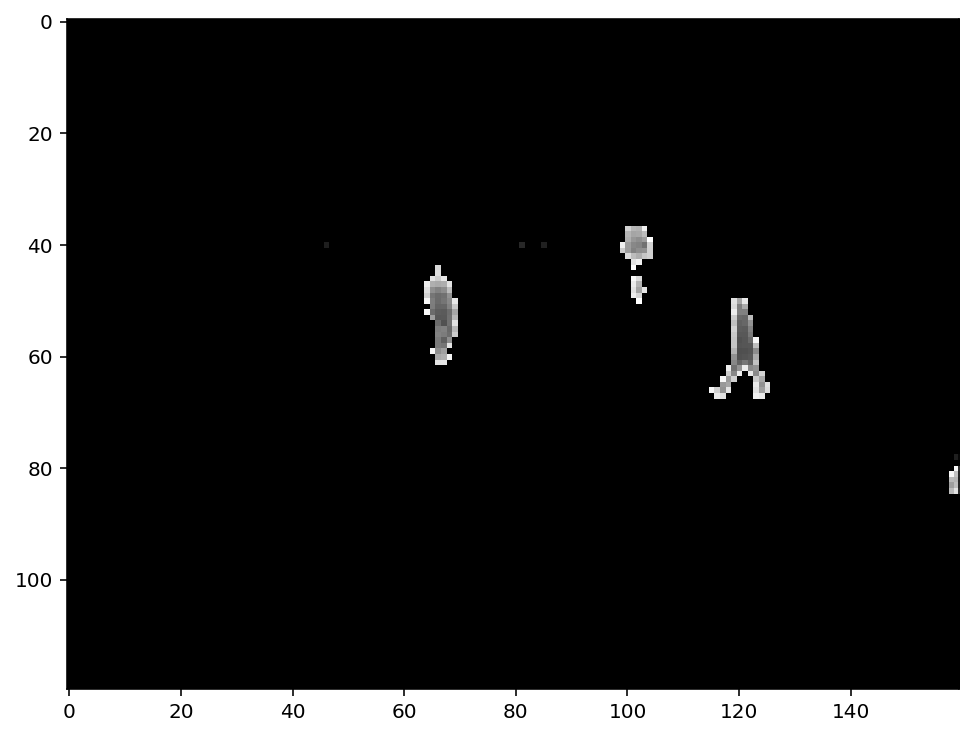

In [14]:
people[(people < 25) | (people > 210)] = 0
plt.imshow(people[:,140].reshape(dims), cmap='gray');

It's a bit noisy so... Let's keep the background but use SVD for the foregound.

Apply SVD

In [15]:
# this takes a while...
U, s, Vh = decomposition.randomized_svd(M, 2)
U.shape, s.shape, Vh.shape
np.savez('data/svd_components', U, s, Vh)

Create a low rank approximation of the video matrix

In [16]:
# this takes a while...
low_rank_M = U @ np.diag(s) @ Vh
np.save('data/low_rank_video_matrix', low_rank_M)
low_rank_M.shape

(19200, 11300)

Extract only the people

In [17]:
people = M - low_rank_M

## Make a video

Make a video of people walking around in the abyss

In [19]:
# this takes a while
people_frames = people.reshape((dims[0], dims[1], -1))

fig, ax = plt.subplots()
def make_frame(t):
    ax.clear()
    ax.imshow(people_frames[...,int(t*fps)])
    return mplfig_to_npimage(fig)

animation = mpy.VideoClip(make_frame, duration=int(video.duration-1))
animation.write_videofile('data/people.mp4', fps=fps)